In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torchvision.utils import make_grid
import torchvision
from torchvision import models
from torchvision import utils
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import itertools
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import datetime
import matplotlib.pyplot as plt

In [2]:
img_size = 28
num_batches = 64
learning_rate = 0.0002
transform = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

C:\Users\april\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [3]:
fmnist = torchvision.datasets.FashionMNIST(root="./", train=True,
transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=fmnist,
batch_size=64, shuffle=True)

In [4]:

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ##use an embedding layer for the label:

In [5]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10) #***
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),  #784+10 feed the augmented input with K classes
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256), #***feed the augmented input with K classes
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [8]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

Starting epoch 0...
g_loss: 3.6137495040893555, d_loss: 0.26991623640060425


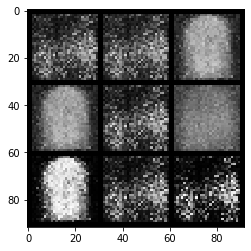

Starting epoch 1...
g_loss: 4.170307636260986, d_loss: 0.2873261570930481


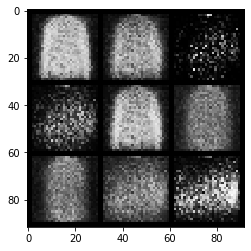

Starting epoch 2...
g_loss: 3.529539108276367, d_loss: 0.4385201930999756


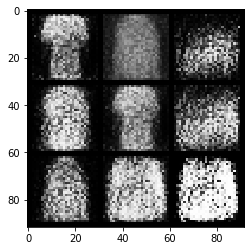

Starting epoch 3...
g_loss: 2.8322319984436035, d_loss: 0.5503818988800049


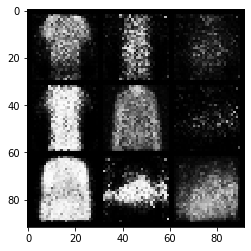

Starting epoch 4...
g_loss: 2.426217794418335, d_loss: 0.9545244574546814


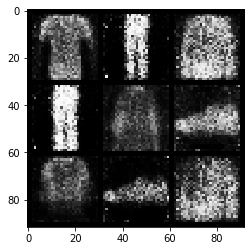

Starting epoch 5...
g_loss: 2.562246322631836, d_loss: 0.4635554850101471


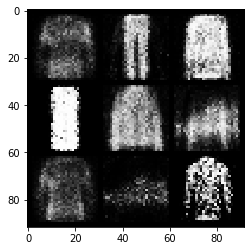

Starting epoch 6...
g_loss: 1.997903823852539, d_loss: 0.6688878536224365


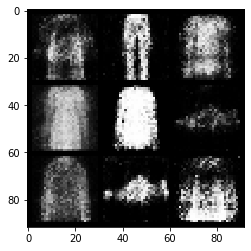

Starting epoch 7...
g_loss: 2.3861477375030518, d_loss: 0.6053519248962402


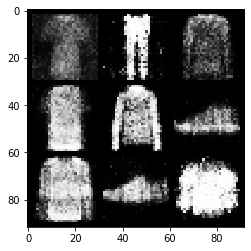

Starting epoch 8...
g_loss: 1.7261022329330444, d_loss: 0.9287993907928467


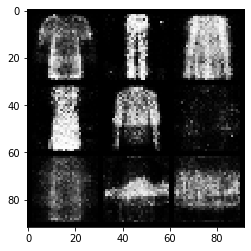

Starting epoch 9...
g_loss: 1.7627800703048706, d_loss: 0.580868124961853


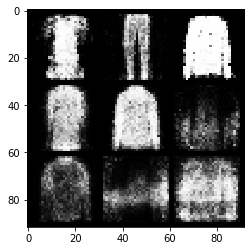

Starting epoch 10...
g_loss: 2.17900013923645, d_loss: 0.7012085914611816


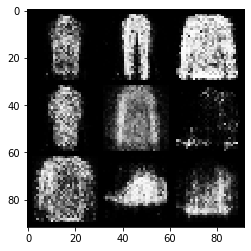

Starting epoch 11...
g_loss: 1.9882895946502686, d_loss: 1.1480903625488281


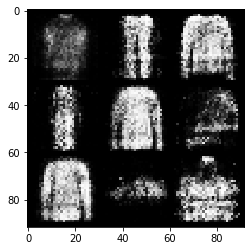

Starting epoch 12...
g_loss: 1.7726114988327026, d_loss: 1.018675446510315


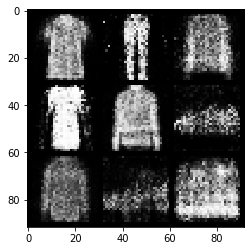

Starting epoch 13...
g_loss: 2.0197975635528564, d_loss: 1.3928934335708618


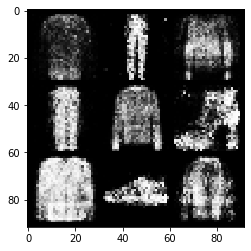

Starting epoch 14...
g_loss: 1.5680639743804932, d_loss: 0.9385615587234497


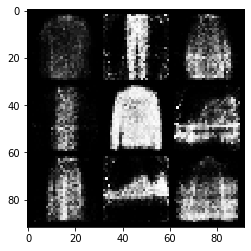

Starting epoch 15...
g_loss: 1.5893750190734863, d_loss: 0.9667673110961914


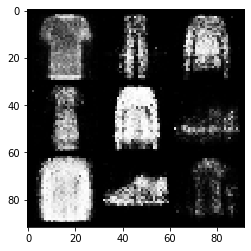

Starting epoch 16...
g_loss: 1.5509192943572998, d_loss: 0.9381651878356934


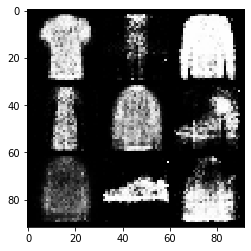

Starting epoch 17...
g_loss: 1.3891851902008057, d_loss: 0.8828896880149841


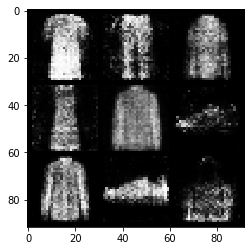

Starting epoch 18...
g_loss: 1.633401870727539, d_loss: 0.7008072733879089


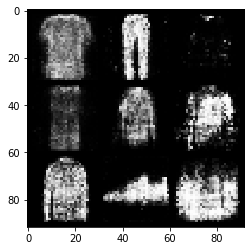

Starting epoch 19...
g_loss: 1.3872392177581787, d_loss: 1.1880351305007935


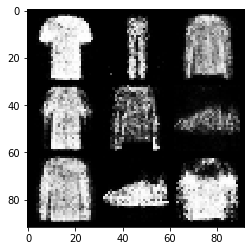

Starting epoch 20...
g_loss: 1.299011468887329, d_loss: 1.114415168762207


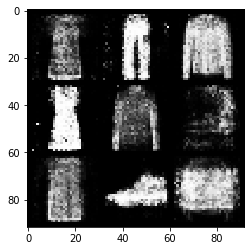

Starting epoch 21...
g_loss: 1.4004393815994263, d_loss: 0.9144359230995178


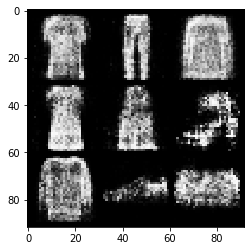

Starting epoch 22...
g_loss: 1.4822540283203125, d_loss: 1.0952666997909546


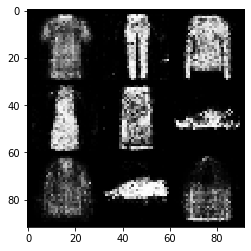

Starting epoch 23...
g_loss: 1.5197904109954834, d_loss: 1.0393894910812378


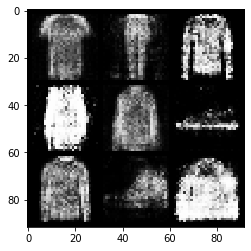

Starting epoch 24...
g_loss: 1.3133304119110107, d_loss: 0.9000848531723022


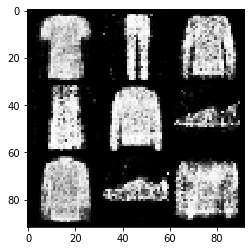

Starting epoch 25...
g_loss: 1.106689691543579, d_loss: 1.300357699394226


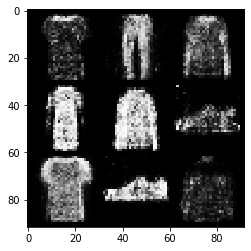

Starting epoch 26...
g_loss: 1.2324758768081665, d_loss: 1.1171196699142456


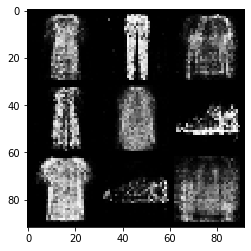

Starting epoch 27...
g_loss: 1.1439143419265747, d_loss: 1.050544023513794


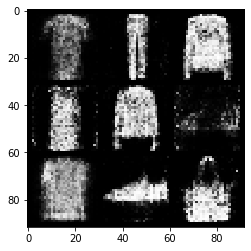

Starting epoch 28...
g_loss: 1.4129595756530762, d_loss: 0.9977902173995972


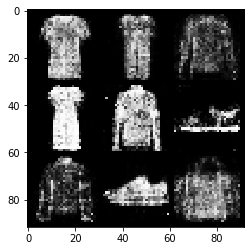

Starting epoch 29...
g_loss: 1.1151694059371948, d_loss: 1.1172423362731934


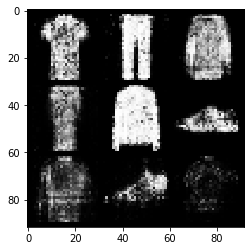

Starting epoch 30...
g_loss: 1.3859201669692993, d_loss: 1.0664807558059692


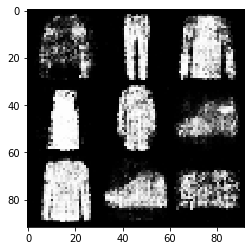

Starting epoch 31...
g_loss: 1.1477618217468262, d_loss: 1.1740268468856812


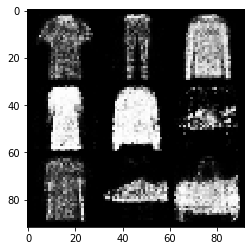

Starting epoch 32...
g_loss: 1.0089502334594727, d_loss: 1.093682050704956


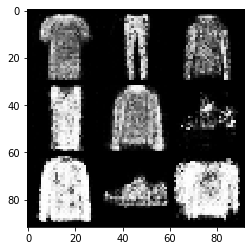

Starting epoch 33...
g_loss: 1.1213682889938354, d_loss: 1.15854012966156


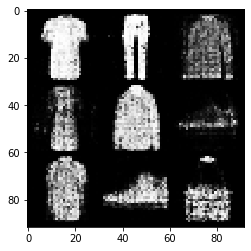

Starting epoch 34...
g_loss: 1.0553162097930908, d_loss: 1.0590156316757202


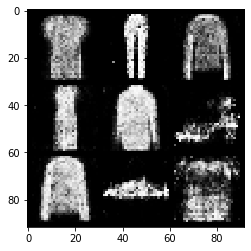

Starting epoch 35...
g_loss: 0.9589738845825195, d_loss: 1.1380976438522339


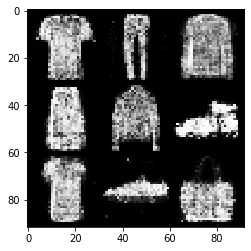

Starting epoch 36...
g_loss: 1.2199910879135132, d_loss: 1.1108243465423584


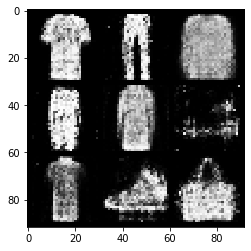

Starting epoch 37...
g_loss: 0.969624400138855, d_loss: 1.1397995948791504


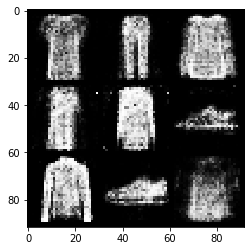

Starting epoch 38...
g_loss: 1.0655776262283325, d_loss: 0.9484838247299194


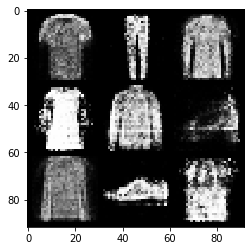

Starting epoch 39...
g_loss: 1.025585412979126, d_loss: 1.2866361141204834


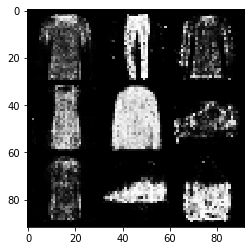

In [9]:
num_epochs = 40
n_critic = 6
display_step = 400
D_losses = []
G_losses = []
for epoch in range(num_epochs):
    
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    G_losses.append(g_loss)
    D_losses.append(d_loss)
        
    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

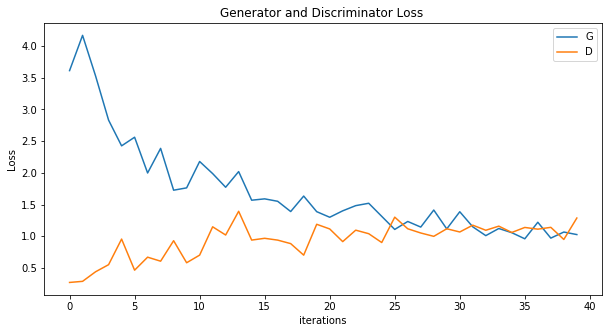

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss ")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

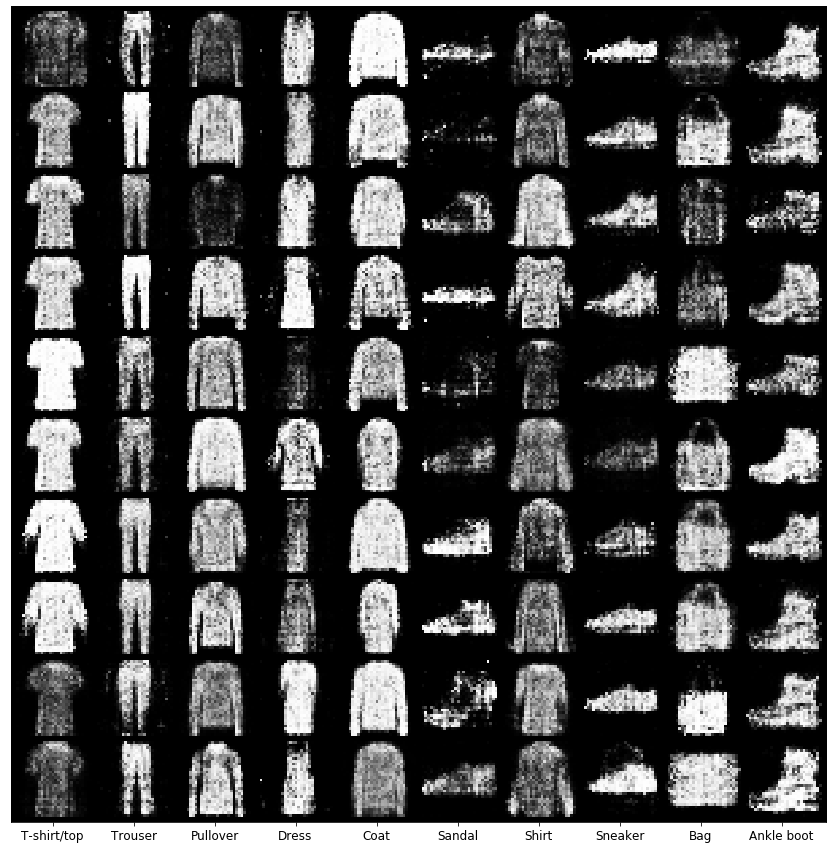

In [11]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), classes, fontsize=12)